# Minibatch Stochastic Gradient Descent

Trong học sâu, việc tối ưu hóa các tham số của mô hình là một bước quan trọng để đạt được hiệu suất tốt nhất. Có nhiều phương pháp tối ưu hóa khác nhau, trong đó Gradient Descent (GD) và Stochastic Gradient Descent (SGD) là hai phương pháp phổ biến. Tuy nhiên, cả hai đều có những hạn chế riêng. Minibatch Stochastic Gradient Descent (Minibatch SGD) được xem là một giải pháp cân bằng giữa hai phương pháp này, mang lại hiệu quả cả về mặt tính toán và thống kê.

## Vectorization and Caches

Trọng tâm của quyết định sử dụng minibatches là hiệu quả tính toán. Điều này dễ hiểu nhất khi xem xét song song với nhiều GPU và nhiều máy chủ. Trong trường hợp này, chúng ta cần gửi ít nhất một hình ảnh cho mỗi GPU. Với 8 GPU trên mỗi máy chủ và 16 máy chủ, ta có minibatch kích thước 128. 

Vấn đề trở nên nhạy cảm hơn đối với GPU đơn hay ngay cả CPU đơn. Các thiết bị này có nhiều loại bộ nhớ, thường là nhiều loại đơn vị tính toán và hạn chế băng thông khác nhau giữa chúng. Ví dụ, CPU có một số lượng nhỏ các thanh ghi và sau đó là L1, L2 và trong một số trường hợp thậm chí bộ nhớ cache L3 (được chia sẻ giữa các lõi bộ xử lý khác nhau). Các bộ nhớ đệm này có kích thước và độ trễ ngày càng tăng (đồng thời chúng giảm băng thông). Nó đủ để nói, bộ xử lý có khả năng thực hiện nhiều hoạt động hơn so với những gì giao diện bộ nhớ chính có thể cung cấp. 

* CPU 2GHz với 16 lõi và vectorization AVX-512 có thể xử lý lên đến $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ byte mỗi giây. Khả năng của GPU dễ dàng vượt quá con số này theo hệ số 100. Mặt khác, một bộ xử lý máy chủ tầm trung có thể không có nhiều hơn 100 Gb/s băng thông, tức là, ít hơn một phần mười những gì sẽ được yêu cầu để giữ cho bộ xử lý ăn. Vấn đề còn tồi tệ hơn khi ta xét đến việc không phải khả năng truy cập bộ nhớ nào cũng như nhau: đầu tiên, giao diện bộ nhớ thường rộng 64 bit hoặc rộng hơn (ví dụ, trên GPU lên đến 384 bit), do đó việc đọc một byte duy nhất vẫn sẽ phải chịu chi phí giống như truy cập một khoảng bộ nhớ rộng hơn.
* Tổng chi phí cho lần truy cập đầu tiên là khá lớn, trong khi truy cập liên tiếp thường hao tổn ít. Có rất nhiều điều cần lưu ý, ví dụ như lưu trữ đệm khi ta có nhiều điểm truy cập cuối, chiplet và các cấu trúc khác...

Cách để giảm bớt những hạn chế này là sử dụng một hệ thống phân cấp của bộ nhớ cache CPU thực sự đủ nhanh để cung cấp cho bộ xử lý dữ liệu. Đây là *động lực* đằng sau việc sử dụng batch trong học sâu. ĐĐể đơn giản, xét phép nhân hai ma trận $\mathbf{A} = \mathbf{B}\mathbf{C}$. Để tính $\mathbf{A}$ ta có khá nhiều lựa chọn, ví dụ như: 

1. Ta có thể tính $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$, tức là tính từng phần tử bằng tích vô hướng.
1. Ta có thể tính $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$, ttức là tính theo từng cột. Tương tự, ta có thể tính $\mathbf{A}$ theo từng hàng $\mathbf{A}_{i,:}$.
1. Ta đơn giản có thể tính $\mathbf{A} = \mathbf{B} \mathbf{C}$.
1. Ta có thể chia $\mathbf{B}$ và $\mathbf{C}$ thành các ma trận khối nhỏ hơn và tính toán $\mathbf{A}$ theo từng khối một.

Nếu sử dụng cách đầu tiên, ta cần sao chép một vector cột và một vector hàng vào CPU cho mỗi lần tính phần tử $\mathbf{A}_{ij}$. Tệ hơn nữa, do các phần tử của ma trận được lưu thành một dãy liên tục dưới bộ nhớ, ta buộc phải truy cập nhiều vùng nhớ rời rạc khi đọc một trong hai vector từ bộ nhớ. Cách thứ hai tốt hơn nhiều. Theo cách này, ta có thể giữ vector cột $\mathbf{C}_{:,j}$ trong vùng nhớ đệm của CPU trong khi ta tiếp tục quét qua $\mathbf{B}$. Cách này chỉ cần nửa băng thông cần thiết của bộ nhớ, do đó truy cập nhanh hơn. Đương nhiên cách thứ ba là tốt nhất. Đáng tiếc rằng đa số ma trận quá lớn để có thể đưa vào vùng nhớ đệm (dù sao đây cũng chính là điều ta đang thảo luận). Cách thứ tư là một phương pháp thay thế khá tốt: đưa các khối của ma trận vào vùng nhớ đệm và thực hiện phép nhân cục bộ. Các thư viện đã được tối ưu sẽ thực hiện việc này giúp chúng ta. Hãy xem xét hiệu suất của từng phương pháp trong thực tế. 

Ngoài hiệu suất tính toán, chi phí tính toán phát sinh đến từ Python và framework học sâu cũng đáng cân nhắc. Mỗi lần ta thực hiện một câu lệnh, bộ thông dịch Python gửi một câu lệnh đến MXNet để chèn câu lệnh đó vào đồ thị tính toán và thực thi nó theo đúng lịnh trình. Chi phí đó có thể khá bất lợi. Nói ngắn gọn, nên áp dụng vector hóa (và ma trận) bất cứ khi nào có thể.

In [1]:
import time
import numpy as np
import torch
from torch import nn
import d2l

A = torch.zeros(512, 512)
B = torch.randn(512, 512)
C = torch.randn(512, 512)

Vì chúng ta sẽ thường xuyên đo thời gian chạy trong phần còn lại của báo cáo, hãy định nghĩa một bộ đếm thời gian.

In [2]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

timer = Timer()

Gán từng phần tử đơn giản là lặp qua tất cả các hàng và cột của $\mathbf{B}$ và $\mathbf{C}$ tương ứng để gán giá trị cho $\mathbf{A}$.

In [3]:
# Compute A = BC one element at a time
timer.start()
for i in range(512):
    for j in range(512):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

9.695973634719849

Một chiến lược nhanh hơn là thực hiện gán theo cột.

In [4]:
# Compute A = BC one column at a time
timer.start()
for j in range(512):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.145216703414917

Cuối cùng, phương pháp hiệu quả nhất là thực hiện toàn bộ phép toán trong một khối duy nhất.
Lưu ý rằng việc nhân hai ma trận $\mathbf{B} \in \mathbb{R}^{m \times n}$ và $\mathbf{C} \in \mathbb{R}^{n \times p}$ cần khoảng $2mnp$ phép toán dấu phẩy động,
khi phép nhân và cộng vô hướng được tính là hai phép toán riêng biệt (mặc dù trên thực tế thường được gộp lại).
Do đó, việc nhân hai ma trận kích thước $512 \times 512$ cần khoảng $0.27$ tỷ phép toán dấu phẩy động.
Bây giờ, hãy cùng xem tốc độ tương ứng của các phép toán này.

In [5]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

gigaflops = [0.27 / i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.028, column 1.859, full 29.816


## Minibatches

Ở các phần trước ta đọc dữ liệu theo *minibatches* thay vì từng điểm dữ liệu đơn lẻ để cập nhật các tham số. Ta có thể giải thích ngắn gọn mục đích như sau. Xử lý từng điểm dữ liệu đơn lẻ đòi hỏi phải thực hiện rất nhiều phép nhân ma trận với vector (hay thậm chí vector với vector). Cách này khá tốn kém và đồng thời phải chịu thêm chi phí khá lớn đến từ các framework học sâu bên dưới. Vấn đề này xảy ra ở cả lúc đánh giá một mạng với dữ liệu mới và khi tính toán gradient để cập nhật các tham số. Tức là vấn đề xảy ra mỗi khi ta thực hiện $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$  trong đó 

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

Ta có thể tăng hiệu suất *tính toán* của phép tính này bằng cách áp dụng nó trên mỗi minibatch dữ liệu. Tức là ta thay thế gradient $\mathbf{g}_t$ trên một điểm dữ liệu đơn lẻ bằng gradient trên một batch nhỏ. 

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

Hãy thử xem phương pháp trên tác động thế nào đến các tính chất thống kê của $\mathbf{g}_t$: vì cả $\mathbf{x}_t$ và tất cả các phần tử trong minibatch $\mathcal{B}_t$ được lấy ra từ tập huấn luyện với xác suất như nhau, kỳ vọng của gradient là không đổi. Mặt khác, phương sai giảm một cách đáng kể. Do gradient của minibatch là trung bình của $b := |\mathcal{B}_t|$ gradient độc lập, độ lệch chuẩn của nó giảm đi theo hệ số $b^{-\frac{1}{2}}$. Đây là một điều tốt, cách cập nhật này có độ tin cậy gần bằng việc lấy gradient trên toàn bộ tập dữ liệu.

Từ ý trên, ta sẽ nhanh chóng cho rằng chọn minibatch $\mathcal{B}_t$ lớn luôn là tốt nhất. Tiếc rằng đến một mức độ nào đó, độ lệch chuẩn sẽ giảm không đáng kể so với chi phí tính toán tăng tuyến tính. Do đó trong thực tế, ta sẽ chọn kích thước minibatch đủ lớn để hiệu suất tính toán cao trong khi vẫn đủ để đưa vào bộ nhớ của GPU. Để minh hoạ quá trình lưu trữ này, hãy xem đoạn mã nguồn dưới đây. Trong đó ta vẫn thực hiện phép nhân ma trận với ma trận, tuy nhiên lần này ta tách thành từng minibatch 64 cột.

In [6]:
timer.start()
for j in range(0, 512, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {0.27 / timer.times[3]:.3f}')

performance in Gigaflops: block 32.902


Có thể thấy quá trình tính toán trên minibatch về cơ bản có hiệu suất gần bằng thực hiện trên toàn ma trận. Tuy nhiên, cần lưu ý rằng Trong ví dụ trước đó ta sử dụng một loại điều chuẩn phụ thuộc chặt chẽ vào phương sai của minibatch. khi tăng kích thước minibatch, phương sai giảm xuống và cùng với đó là lợi ích của việc thêm nhiễu (noise-injection) cũng giảm theo do phương pháp chuẩn hóa theo batch.

## Reading the Dataset

Chúng ta hãy xem cách minibatches được tạo ra hiệu quả từ dữ liệu. Sau đây chúng tôi sử dụng một tập dữ liệu do NASA phát triển để kiểm tra cánh [noise from different aircraft](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) để so sánh các thuật toán tối ưu hóa này. Để thuận tiện, chúng tôi chỉ sử dụng các ví dụ $1,500$ đầu tiên. Dữ liệu được làm trắng để xử lý trước, tức là, chúng tôi loại bỏ trung bình và giải thích phương sai thành $1$ cho mỗi tọa độ.

In [7]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1] - 1

## Hiện thực từ đầu

Để so sánh hiệu năng giữa 3 thuật toán tối ưu là GD, SGD và SGD theo minibatch, ta sẽ sử dụng mô hình Hồi quy Tuyến tính

### Nhắc lại về Hồi quy Tuyến tính

#### Định nghĩa
Hồi quy Tuyến tính (Linear Regression) là một phương pháp học máy cơ bản thuộc nhóm học có giám sát (Supervised learning). Phương pháp này bao gồm 2 yếu tố là Hồi quy và Tuyến tính. Phép Hồi quy phân tích mối quan hệ giữa một hoặc nhiều biến đầu vào (biến độc lập) và một biến đầu ra (biến phụ thuộc). Trong khi đó, phép Tuyến tính chỉ mối quan hệ tổ hợp tuyến tính của các biến đầu vào mà không có sự xuất hiện của các hàm lũy thừa hay phi tuyến như sin, log, relu, ... Như vậy, Hồi quy Tuyến tính là phương pháp học máy và thống kê giúp mô hình hóa mối quan hệ **tuyến tính** giữa một hoặc nhiều biến đầu vào (biến độc lập) và một biến đầu ra (biến phụ thuộc), từ đó giúp dự đoán giá trị của biến phụ thuộc dựa trên giá trị của các biến độc lập.

#### Mô hình Tuyến tính
Mô hình Hồi quy Tuyến tính cho `d` đặc trưng (biến đầu vào) có dạng:
$$
y = \omega_1*x_1 + \omega_2*x_2 + ... + \omega_d*x_d + b
$$
Thu thập toàn bộ các đặc trưng vào một vector $\mathbf{x}$ và toàn bộ các trọng số vào một vector $\boldsymbol{\omega}$, ta có thể biểu diễn mô hình dưới dạng tích vô hướng của 2 vector:
$$
y = \boldsymbol{\omega}^T*\mathbf{x}
$$
Trong đó:
- $\mathbf{x}$: vector đặc trưng đầu vào, $\mathbf{x} \in R^d$ (input features)
- $\boldsymbol{\omega}$: vector trọng số (weights) cần huấn luyện
- $b$: độ lệch (bias)
- $y$: giá trị đầu ra (output)


#### Hàm mất mát
Để đánh giá mức độ khớp giữa mô hình được xây dựng và dữ liệu, ta sử dụng hàm mất mát. Hàm mất mát định lượng khoảng cách giữa giá trị thực $y$ và giá trị dự đoán $\hat{y}$ của mục tiêu. Độ mất mát thường là một số không âm và có giá trị càng nhỏ càng tốt. Khi các dự đoán hoàn hảo, chúng sẽ có độ mất mát sẽ bằng **0**. Hàm mất mát thông dụng nhất trong các bài toán hồi quy là hàm tổng bình phương các lỗi - Mean Squared Error (MSE):
$$
L_i = \frac{1}{2} MSE(y_i, \hat{y}_i) = \frac{1}{2} E[(y_i - \hat{y}_i)^2] = \frac{1}{2} (y_i - \hat{y}_i)^2
$$
Hằng số **1/2** không tạo ra sự khác biệt thực sự nào nhưng sẽ giúp ký hiệu thuận tiện hơn:nó sẽ được triệt tiêu khi lấy đạo hàm của hàm mất mát.

Lưu ý rằng khi hiệu giữa giá trị thực $y_i$ và giá trị ước lượng $\hat{y}_i$ lớn, giá trị hàm mất mát sẽ tăng rất lớn cho sự phụ thuộc bậc 2. Để đo chất lượng của mô hình trên toàn bộ tập dữ liệu, ta đơn thuần lấy trung bình (hay tương đương là lấy tổng) các giá trị mất mát của từng mẫu trong tập huấn luyện.
$$
L = \frac{1}{n} \sum_{i=1}^{n} L_i = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2} (y_i - \hat{y}_i)^2
$$


#### Mục tiêu
Khi huấn luyện mô hình, ta muốn tìm các tham số $\boldsymbol{\omega}^*$ và $b^*$ sao cho tổng độ mất mát trên toàn bộ các mẫu huấn luyện được cực tiểu hóa:
$$
\boldsymbol{\omega}^*, b^* = \underset{\boldsymbol{\omega}, b}{\text{argmin}}\:L(\boldsymbol{\omega}, b)
$$

Kỹ thuật chính để tối ưu hóa mô hình này, cũng như các mô hình học sâu khác, bao gồm việc giảm thiểu lỗi qua các vòng lặp bằng cách cập nhật tham số theo hướng làm giảm gần hàm mát mát. Với các hàm mất mát mặt lồi, giá trị mất mát cuối cùng sẽ hội tụ về giá trị nhỏ nhất. Tuy điều tương tự không thể áp dụng cho các mặt không lồi, ít nhất thuật toán sẽ dẫn tới một cực tiểu (hy vọng là tốt)

Đơn giản nhất ta có thể kể đến là việc tính đạo hàm của hàm mất mát, tức trung bình của các giá trị mất mát được tính trên mỗi mẫu của tập dữ liệu. Cuối cùng, gradient này được nhân với tốc độ học $\eta > 0$ và kết quả này được trừ đi từ các giá trị tham số hiện tại. Đây là chính phương pháp Gradient Descent (GD).

Việc cập nhật có thể được biểu diễn bằng công thức dưới đây:
$$
(\boldsymbol{\omega}, b) \leftarrow (\boldsymbol{\omega}, b) - \frac{\eta}{|\boldsymbol{N}|} \sum_{i \in \boldsymbol{N}} \partial_{(\boldsymbol{\omega}, b)}L_i(\boldsymbol{\omega}, b)
$$
hay,
$$
\boldsymbol{\omega} \leftarrow \boldsymbol{\omega} - \frac{\eta}{|\boldsymbol{N}|} \sum_{i \in \boldsymbol{N}} \partial_(\boldsymbol{\omega}) L_i(\boldsymbol{\omega}, b)
$$
$$
b \leftarrow b - \frac{\eta}{|\boldsymbol{N}|} \sum_{i \in \boldsymbol{N}} \partial_{b} L_i(\boldsymbol{\omega}, b)
$$

Việc cập nhật này cho từng mẫu dữ liệu có thể cực kì chậm. Nếu chúng ta chỉ muốn lấy một minibatch ngẫu nhiên các mẫu mỗi khi ta cần tính bước cập nhật, phương pháp biến thể này là Stochastic Gradient Descent (SGD). Trong mỗi vòng lặp, đầu tiên chúng ta lấy ngẫu nhiên một minibatch $\boldsymbol{B}$ dữ liệu huấn luyện với kích thước cố định. Sau đó, chúng ta tính đạo hàm của hàm mất mát trên minibatch đó theo các tham số của mô hình. Cuối cùng, gradient này được nhân với tốc độ học  $\eta > 0$ và kết quả này được trừ đi từ các giá trị tham số hiện tại.

Việc cập nhật có thể được biểu diễn bằng công thức dưới đây:
$$
(\boldsymbol{\omega}, b) \leftarrow (\boldsymbol{\omega}, b) - \frac{\eta}{|\boldsymbol{B}|} \sum_{i \in \boldsymbol{B}} \partial_{(\boldsymbol{\omega}, b)}L_i(\boldsymbol{\omega}, b)
$$
hay,
$$
\boldsymbol{\omega} \leftarrow \boldsymbol{\omega} - \frac{\eta}{|\boldsymbol{B}|} \sum_{i \in \boldsymbol{B}} \partial_(\boldsymbol{\omega}) L_i(\boldsymbol{\omega}, b)
$$
$$
b \leftarrow b - \frac{\eta}{|\boldsymbol{B}N|} \sum_{i \in \boldsymbol{B}} \partial_{b} L_i(\boldsymbol{\omega}, b)
$$

### Ứng dụng các Thuật toán tối ưu cho Hồi quy Tuyến tính

Để thuận tiện, hàm lập trình GD, SGD và SGD theo minibatch sẽ có danh sách tham số giống nhau. Cụ thể, chúng ta thêm trạng thái đầu vào biến `states` và đặt siêu tham số trong biến `hyperparams`. Bên cạnh đó, chúng ta sẽ tính giá trị mất mát trung bình của từng minibatch trong hàm huấn luyện, từ đó không cần phải chia gradient cho kích thước batch trong thuật toán tối ưu nữa. 

In [8]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

**Giải thích**

Hàm `sgd` sẽ duyệt qua các tham số `p` trong `params` của mô hình, trong bài toán Hồi quy Tuyến tính sẽ là vector trọng số $\boldsymbol{\omega}$ và $b$ và cập nhật theo quy tắc:
$$
p := p - \eta*\Delta_pL
$$
Trong đó:
- `p`: tham số
- `p.grad`: đạo hàm của hàm mất mát theo p
- `hyperparams['lr']` hay $\eta$: tốc độ học (learning rate)
Sau đó, thực hiện reset gradient ở bước cuối trong mỗi vòng lặp để tránh tích lũy gradient từ nhiều batch

Tiếp theo, chúng ta hiện thực một hàm huấn luyện tổng quát, sử dụng được cho tất cả các thuật toán tối ưu. Hàm sẽ khởi tạo một mô hình Hồi quy Tuyến tính và có thể được sử dụng để huấn luyện mô hình với GD, SGD và SGD theo minibatch.

In [9]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

**Giải thích**

Hàm `train_ch11` sẽ khởi tạo các giá trị cần cho mô hình Hồi quy Tuyến tính và thực hiện huấn luyện.

Tham số đầu vào:
- `trainer_fn`: hàm cập nhật tham số mô hình (GD, SGD, ...)
- `states`: các trạng thái cần thiết cho `trainer_fn`
- `hyperparams`: các siêu tham số như `lr`, `beta`
- `feature_dim`: số lượng đặc trưng (hoặc số chiều biến đầu vào)
- `num_epochs`: số vòng lặp huấn luyện

**Bước 1: Khởi tạo mô hình**
Đầu tiên, khởi tạo 2 vector trọng số $\boldsymbol{\omega}$ và bias $b$ đều yêu cầu gradient, trong đó:
- $\boldsymbol{\omega}$ tuân theo phân phối chuẩn với $\mu$ = 0.0 và $\sigma$ = 0.01, có kích thước `feature_dim` x 1 
- $b$ = 0

Tiếp theo, khởi tạo `net` với `loss`, lần lượt là mô hình Hồi quy tuyến tính có dạng $y = \boldsymbol{X}*\boldsymbol{\omega} + b$ và hàm mất mát theo MSE

**Bước 2: Khởi tạo tiến trình vẽ hàm mất mát và bộ đếm thời gian**
- `animator`: thực thể để biểu diễn hàm mất mát dưới dạng đồ thị theo thời gian
- `n`: tổng số mẫu đã xử lý
- `timer`: để đo thời gian chạy từng epoch

**Bước 3: Huấn luyện mô hình**
Lần lượt duyệt qua từng batch:
1. Tính giá trị hàm mất mát: `l = loss(net(X), y).mean()` tương ứng việc lấy trung bình giá trị MSE cho toàn bộ các điểm dữ liệu trong batch
2. Thực hiện lan truyền ngược để tính GD: `l.backward()`
3. Cập nhật tham số: `trainer_fn` được gọi với `[w, b]`, `states` và `hyperparams`
4. Reset gradient descent nằm trong `trainer_fn`.

Vẽ hàm mất mát với mỗi 200 mẫu

**Bước 4: In kết quả**
In giá trị hàm mất mát cuối cùng và thời gian trung bình mỗi epoch

Tiếp theo, ta tạo một hàm đầu vào để thực hiện toàn quá trình

In [10]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

**Giải thích**
Hàm `train_sgd` thực hiện việc đọc dữ liệu, khởi tạo các tham số và huấn luyện mô hình.

Tham số đầu vào:
- `lr`: siêu tham số tốc độ học (learning rate)
- `batch_size`: kích thước của batch
- `num_epochs`: số vòng lặp huấn luyện

Dữ liệu được trả về theo từng batch từ hàm `get_data_ch11` sẽ được dùng để huấn luyện trong hàm `train_ch11`

#### Thực nghiệm với GD
Hãy cùng quan sát quá trình tối ưu của thuật toán Gradient Descent (GD) theo toàn bộ batch. Ta có thể sử dụng toàn bộ batch bằng cách thiết lập kích thước minibatch bằng tổng số mẫu (trong trường hợp này là 1500). Kết quả là các tham số mô hình chỉ được cập nhật một lần duy nhất trong mỗi epoch. Có thể thấy không có tiến triển nào đáng kể. Trong ví dụ, việc tối ưu bị ngừng trệ sau 6 epoch.

loss: 0.251, 0.045 sec/epoch


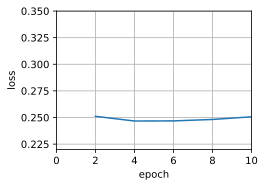

In [11]:
gd_res = train_sgd(1, 1500, 10)

**Giải thích**

Ở đây ta thực nghiệm huấn luyện mô hình với GD, sử dụng $\eta = 1$, số lượng epoch = 10 và thiết lập tham số `batch_size` = 1500 (= kích thước của tập dữ liệu), tức là với mỗi epoch hàm mất mát sẽ được tính và thực hiện cập nhật $(\boldsymbol{\omega}, b)$ chỉ 1 lần duy nhất

#### Thực nghiệm với SGD

Khi kích thước của batch bằng 1, chúng ta sử dụng thuật toán SGD để tối ưu. Để đơn giản hóa việc hiện thực, chúng ta cố định tốc độ học (learning rate) bằng một hằng số (có giá trị nhỏ). Trong SGD, các tham số mô hình được cập nhật bất cứ khi nào có một mẫu huấn luyện được xử lý. Trong trường hợp này, sẽ có 1500 lần cập nhật trong mỗi epoch. Có thể thấy, sự suy giảm giá trị của hàm mục tiêu chậm lại sau một epoch. Mặc dù cả hai thuật toán cùng xử lý 1500 mẫu trong một epoch, SGD tốn thời gian hơn GD trong thí nghiệm trên. Điều này là do SGD cập nhật các tham số thường xuyên hơn và kém hiệu quả khi xử lý đơn lẻ từng mẫu.

loss: 0.246, 0.718 sec/epoch


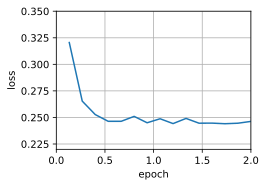

In [12]:
sgd_res = train_sgd(0.005, 1)

**Giải thích**

Ở đây ta thực nghiệm huấn luyện mô hình với SGD, sử dụng $\eta = 0.005$, số lượng epoch = 2 (theo mặc định) và thiết lập tham số `batch_size` = 1, tức là với mỗi epoch hàm mất mát sẽ được tính và thực hiện cập nhật $(\boldsymbol{\omega}, b)$ với mỗi điểm dữ liệu trong tập.

#### Thực nghiệm với SGD theo minibatch

Cuối cùng, khi kích thước của batch bằng 100, chúng ta sử dụng thuật toán SGD theo minibatch để tối ưu. Thời gian cần thiết cho mỗi epoch ngắn hơn thời gian tương ứng của SGD và GD theo toàn bộ batch.

loss: 0.250, 0.036 sec/epoch


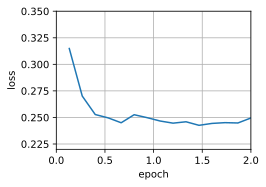

In [13]:
mini1_res = train_sgd(.4, 100)

**Giải thích**

Ở đây ta thực nghiệm huấn luyện mô hình với SGD theo minibatch có kích thước = 100, sử dụng $\eta = 0.4$, số lượng epoch = 2 (theo mặc định), tức là với mỗi epoch hàm mất mát sẽ được tính và thực hiện cập nhật $(\boldsymbol{\omega}, b)$ tương ứng là $\frac{1500}{100} = 15$ lần

Giảm kích thước của batch bằng 10, thời gian cho mỗi epoch tăng vì thực thi tính toán trên mỗi batch kém hiệu quả hơn.

loss: 0.244, 0.109 sec/epoch


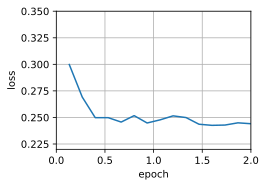

In [14]:
mini2_res = train_sgd(.05, 10)

**Giải thích**

Ở đây ta thực nghiệm huấn luyện mô hình với SGD theo minibatch có kích thước = 10, sử dụng $\eta = 0.05$, số lượng epoch = 2 (theo mặc định), tức là với mỗi epoch hàm mất mát sẽ được tính và thực hiện cập nhật $(\boldsymbol{\omega}, b)$ tương ứng là $\frac{1500}{10} = 150$ lần

Cuối cùng, chúng ta so sánh tương quan thời gian và giá trị hàm mấy mát trong bốn thí nghiệm trên. Có thể thấy, dù hội tụ nhanh hơn GD về số mẫu được xử lý, SGD tốn nhiều thời gian hơn để đạt được cùng giá trị mất mát như GD vì thuật toán này tính gradient descent trên từng mẫu một. Thuật toán SGD theo minibatch có thể cân bằng giữa tốc độ hội tụ và hiệu quả tính toán. Với kích thước minibatch bằng 10, thuật toán này hiệu quả hơn SGD; và với kích thước minibatch bằng 100, thời gian chạy của thuật toán này thậm chí nhanh hơn cả GD.

## Hiện thực chính xác

Trong Gluon, chúng ta có thể sử dụng lớp `Trainer` để gọi các thuật toán tối ưu. Cách này được sử dụng để có thể hiện thực một hàm huấn luyện tổng quát. Chúng ta sẽ sử dụng hàm này xuyên suốt các phần tiếp theo của chương.

In [15]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

loss: 0.242, 0.120 sec/epoch


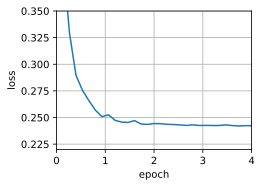

In [16]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Excercises

### Exercise 1.

loss: 0.244, 0.169 sec/epoch


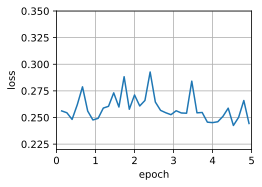

In [17]:
# Thử nghiệm với các giá trị khác nhau của tốc độ học và kích thước batch
# Tốc độ học lớn hơn và kích thước batch nhỏ hơn
experiment_1 = train_sgd(lr=0.1, batch_size=5, num_epochs=5)


loss: 0.281, 0.041 sec/epoch


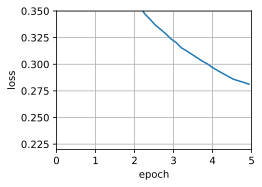

In [18]:
# Tốc độ học nhỏ hơn và kích thước batch lớn hơn
experiment_2 = train_sgd(lr=0.01, batch_size=50, num_epochs=5)


loss: 0.244, 0.077 sec/epoch


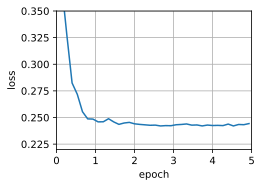

In [19]:
# Tốc độ học trung bình và kích thước batch trung bình
experiment_3 = train_sgd(lr=0.05, batch_size=20, num_epochs=5)

1. **Tốc độ học lớn hơn và kích thước batch nhỏ hơn**:
    - Với tốc độ học lớn và kích thước batch nhỏ, mô hình có thể hội tụ nhanh hơn nhưng dễ gặp phải dao động lớn trong quá trình tối ưu hóa do phương sai cao của gradient.

2. **Tốc độ học nhỏ hơn và kích thước batch lớn hơn**:
    - Với tốc độ học nhỏ và kích thước batch lớn, mô hình hội tụ ổn định hơn nhưng tốc độ hội tụ có thể chậm hơn do các bước cập nhật nhỏ.

3. **Tốc độ học trung bình và kích thước batch trung bình**:
    - Với tốc độ học và kích thước batch trung bình, mô hình đạt được sự cân bằng giữa tốc độ hội tụ và độ ổn định, thường mang lại kết quả tốt nhất.

Kích thước batch và tốc độ học là các siêu tham số quan trọng, cần được điều chỉnh phù hợp với bài toán cụ thể để đạt hiệu quả tối ưu.

### Exercise 2.

In [20]:
import mxnet as mx
from mxnet import gluon, nd

# Define a simple model
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(10))
net.initialize(mx.init.Xavier())

# Initialize Trainer with SGD optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

# Simulate training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Reduce learning rate by a factor of 10 after each epoch
    new_lr = trainer.learning_rate * 0.1
    trainer.set_learning_rate(new_lr)
    print(f'Epoch {epoch+1}: Learning rate = {new_lr}')


Epoch 1: Learning rate = 0.010000000000000002
Epoch 2: Learning rate = 0.0010000000000000002
Epoch 3: Learning rate = 0.00010000000000000003
Epoch 4: Learning rate = 1.0000000000000004e-05
Epoch 5: Learning rate = 1.0000000000000004e-06


In [ ]:
Excercise trên minh họa một kỹ thuật điều chỉnh tốc độ học, trong đó tốc độ học được giảm đi 10 lần sau mỗi epoch. Cách tiếp cận này đảm bảo sự hội tụ mượt mà hơn bằng cách cho phép bộ tối ưu hóa thực hiện các bước nhỏ hơn khi nó tiến gần đến điểm cực tiểu của hàm mất mát. Những kỹ thuật như vậy thường được sử dụng để cải thiện tính ổn định và hiệu suất của quá trình huấn luyện.

### Exercise 3.

Khi huấn luyện mô hình sử dụng phương pháp SGD theo minibatch thông thường, ta có:
- Cách hoạt động:
    + Với mỗi vòng lặp huấn luyện, tập dữ liệu sẽ được chia nhỏ thành các minibatch.
    + Mỗi minibatch chứa các mẫu dữ liệu độc nhất cho đến khi vòng lặp được hoàn thành.
    + Mỗi điểm dữ liệu chỉ được dùng 1 lần mỗi vòng lặp.
- Đặc điểm:
    + Ước lượng gradient hiệu quả: phương sai cho mỗi minibatch tương đối nhỏ.
    + Hội tụ nhanh và mượt mà hơn.
    + Đảm bảo các mẫu đều được xem xét mỗi vòng lặp huấn luyện.

So sánh với biến thể minibatch cho phép lấy mẫu hoàn lại từ tập dữ liệu, ta có:
- Cách hoạt động:
    + Với mỗi vòng lặp huấn luyện, các minibatch sẽ được tạo ra bằng cách lấy ngẫu nhiên từ tập dữ liệu.
    + Một vài mẫu sẽ được chọn nhiều lần, một vài mẫu thì không bao giờ được chọn.
    + Không đảm bảo rằng tất cả các điểm dữ liệu được dùng 1 lần mỗi vòng lặp.
- Đặc điểm:
    + Ước lượng gradient kém hiệu quả: có nhiều nhiễu do bị trùng hoặc thiếu một phần mẫu.
    + Hội tụ chậm hoặc kém ổn định
    + Thiếu tính khái quát hóa do bị overfit với các mẫu dữ liệu được lựa chọn nhiều và underfit với các mẫu dữ liệu không được lựa chọn. 



### Exercise 4.

Nếu tập dữ liệu bị lặp lại, ta đang có kích thước của mẫu quan sát tăng lên nhưng không có thêm thông tin mới. Điều này ảnh hưởng khác nhau đến các phương pháp tối ưu theo các cách khác nhau:
1. Gradient Descent (GD) - Sử dụng toàn bộ mẫu dữ liệu
- Gradient Descent sử dụng toàn bộ mẫu dữ liệu, nên sẽ làm tăng giá trị hàm mất mát và độ dốc theo tỉ lệ thuận. Tuy nhiên, hướng của gradient sẽ không đổi, do ta chỉ cộng các thành phần lặp lại.
- Ảnh hưởng:
    + Hướng của gradient được giữ nguyên, nhưng được tăng lên.
    + Tốc độ học cần phải được điều chỉnh để duy trì được độ ổn định.
    + Chi phí tính toán tăng lên (lâu hơn mỗi vòng lặp nhưng không có thêm thông tin gì)
2. Stochastic Gradient Descent (SGD) – Sử dụng 1 mẫu
- Mỗi mẫu sẽ có khả năng cao hơn được chọn nhiều lần, nhưng không có sự thay đổi về chất lượng gradient và tính đa dạng của tập dữ liệu
- Ảnh hưởng:
    + Không có sự khác biệt cơ bản về quá trình huấn luyện.
    + Phương sai không đổi.
    + Hội tụ chậm hơn do trùng lặp dữ liệu.
3. Minibatch Stochastic Gradient Descent (Minibatch SGD) - Sử dụng tập con
- Các minibatch sẽ chứa nhiều mẫu trùng lặp hơn giữa các vòng lặp huấn luyện.
- Tốc độ học có thể chậm lại do liên tục thấy các mẫu trùng lặp
- Ảnh hưởng:
    + Hướng của gradient được giữ nguyên, nhưng tính khái quát lâu được cải thiện.
    + Có thể tốn các vòng lặp để huấn luyện các mẫu trùng lặp.